<a href="https://colab.research.google.com/github/LuccaKG/Estudos-sobre-Machine-Learning/blob/main/EFC1/EFC_1_Regressao_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center> **Predição de séries temporais -- Manchas solares**<center/>

Nesta atividade, vamos abordar uma instância do problema de regressão de grande
interesse prático e com uma extensa literatura: a **predição de séries temporais**. A fim
de se prever o valor futuro de uma série de medidas de uma determinada grandeza,
um procedimento típico consiste em construir um modelo matemático de estimação
baseado na hipótese de que os valores passados da própria série podem explicar o seu comportamento futuro.
Seja $x(n)$ o valor da série temporal no instante (discreto) $n$ . Então, o modelo construído deve realizar um mapeamento do vetor de entradas $x(n) \in \mathbb{R}^{K \times 1}$, o qual é formado por um subconjunto de K amostras passadas, *$i.e.$*,

$$x(n) = [x(n - 1) \ \dots \ x(n - K)]^T$$

para uma saída $\hat{y}(n)$, que representa uma estimativa do valor futuro da série $x(n)^*$

Neste exercício, vamos trabalhar com a famosa série histórica de medidas do número de manchas solares (sunspots). No caso, dispomos das leituras mensais desde 1749 a 2019, totalizando 3252 amostras. A Figura 1 exibe um registro de mancha solar juntamente com o gráfico da série completa.
<br/>
<br/>

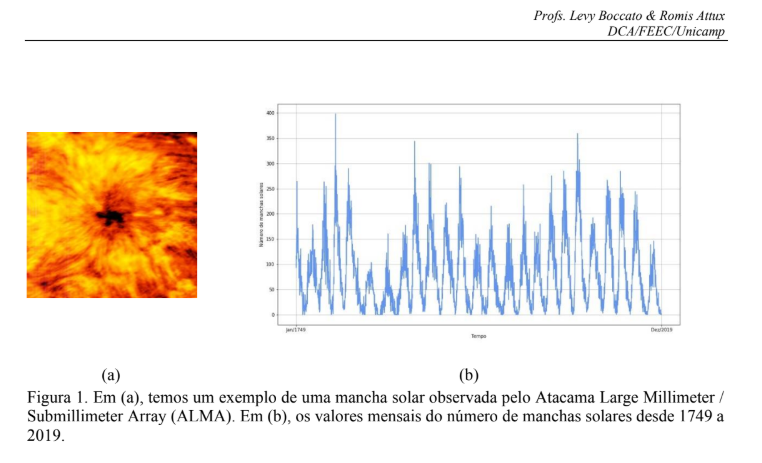



## <center>**Exercício 1 - Modelo linear e validação cruzada**<center/>

Inicialmente, vamos explorar um modelo linear para a previsão, tal que:

$$
\hat{y}(n) = w^T x(n) + w_0
$$


Para o projeto do preditor linear, separe os dados disponíveis em dois conjuntos, um para treinamento e outro para teste. No caso, reserve as amostras referentes aos últimos dez anos (2010-2019) em seu conjunto de teste. Além disso, utilize um esquema de validação cruzada do tipo k-fold para selecionar o melhor valor do hiperparâmetro K.

Faça a análise de desempenho do preditor linear ótimo, no sentido de quadrados
mínimos irrestrito, considerando:
1. A progressão do valor médio da raiz quadrada do erro quadrático médio
(RMSE, do inglês root mean squared error), junto aos dados de validação, em
função do número de entradas (K) do preditor (desde K = 1 a K = 24).
2. O gráfico com as amostras de teste da série temporal e com as respectivas
estimativas geradas pela melhor versão do preditor (i.e., usando o valor de K
que levou ao mínimo erro de validação).

**Observação:** Neste exercício, não é necessário utilizar regularização, nem efetuar
normalizações nos dados.

## Extração de dados

In [2]:
import pandas as pd
import numpy as np

# Carrega os dados do arquivo CSV
df = pd.read_csv('monthly-sunspots.csv')
# df.head() # so para garantir o sucesso na operação

# print(df.columns) # checar nomes exatos das colunas

# Renomeia coluna para que o df fique melhor formatado
df.rename(columns={"Monthly Mean Total Sunspot Number": "Sunspots"}, inplace=True)

# Converte para datetime, o que facilita manipulação
df["Date"] = pd.to_datetime(df["Date"])

# Separa conjunto de treino e teste conforme enunciado
df_train = df[df["Date"] < "2010-01-01"]
df_test = df[df["Date"] >= "2010-01-01"]

# Exibe os primeiros dados para checagem
#df_train.head()
#df_test.head()

# converte para numpy para facilitar manipulações
train_values = df_train["Sunspots"].values
test_values = df_test["Sunspots"].values

## Criando matrizes de entrada


In [3]:
# Vamos primeiro definir as matrizes X (entrada) e Y (saida) da regressao linear

def create_dataset(data, K):
    X = []
    Y = []
    for i in range(K, len(data)):
        X.append(data[i-K:i]) # últimos valores
        Y.append(data[i]) # próximo valor (valor predito)
    return np.array(X), np.array(Y)

K_max = 24 # conforme enunciado, testaremos de K=1 até K=24

# Criar os conjuntos de treino e teste para diferentes valores de K

# Cria um dicionário 'datasets', onde a chave é o valor de K (de 1 até K_max),
# e o valor correspondente é o resultado da função
# create_dataset(train_values, K) para cada K.
datasets = {K: create_dataset(train_values, K) for K in range(1, K_max+1)}
test_X, test_Y = create_dataset(test_values, K_max)


## Calculando os pesos $w$ da regressão
A solução analítica da equação de regressão linear para $w$ é:

\begin{equation}
w = (X^T X)^{-1} X^T Y
\end{equation}


In [4]:
# Calcula os pesos 'w' com base na solução analitica para w da equação
# ŷ(n) = w^T * x(n) + w0

def compute_weights(X, Y):
# Essa linha cria uma nova matriz X_bias onde, à esquerda de X, é adicionada uma
# coluna de 1s para representar o termo de viés w0 no modelo de regressão linear.
  X_bias = np.c_[np.ones(X.shape[0]), X]

  w = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ Y
  return w

# Cria um dicionário 'weights' onde cada chave K (de 1 até K_max) armazena
# os pesos da regressão linear calculados usando os dados de entrada para o valor
# de K, usando a função 'compute_weights' para cada conjunto de dados datasets[K].
weights = {K: compute_weights(*datasets[K]) for K in range(1, K_max + 1)}

## Escolhendo o melhor valor para o hiperparâmetro $K$

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Definindo o número de divisões (folds) como 5, embaralhando os dados e usando
# uma semente fixa (random_state) para reprodutibilidade
kf = KFold(n_splits=5, shuffle=True, random_state=42)
errors = {}  # Dicionário para armazenar os erros de cada valor de K

# Itera sobre diferentes valores de K, de 1 até K_max
for K in range(1, K_max + 1):
    X, Y = datasets[K]  # Obtém as variáveis X (entradas) e Y (saídas) para o valor atual de K
    fold_errors = []  # Lista para armazenar os erros de cada fold (subconjunto de validação)

    # Para cada divisão dos dados em treinamento e validação (com base em KFold)
    for train_idx, val_idx in kf.split(X):
        # Separa os dados de treinamento e validação com base nos índices gerados por KFold
        X_train, X_val = X[train_idx], X[val_idx]
        Y_train, Y_val = Y[train_idx], Y[val_idx]

        # Calcula os pesos da regressão linear usando os dados de treinamento
        w = compute_weights(X_train, Y_train)

        # Adiciona a coluna de 1s (termo de viés) aos dados de validação
        X_val_bias = np.c_[np.ones(X_val.shape[0]), X_val]

        # Realiza a previsão com os dados de validação usando os pesos calculados
        Y_pred = X_val_bias @ w

        # Calcula o erro quadrático médio (RMSE) para as previsões feitas
        rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))

        # Armazena o erro calculado para este fold
        fold_errors.append(rmse)

    # Calcula a média dos erros (RMSE) para todos os folds para o valor atual de K
    errors[K] = np.mean(fold_errors)

# Encontra o valor de K que gera o menor erro médio
best_K = min(errors, key=errors.get)

# Exibe o melhor valor de K e seu respectivo erro médio
print(f"Melhor valor para K: {best_K}")
print(f"Erro médio: {errors[best_K]}")


Melhor valor para K: 24
Erro médio: 24.734565909174066


## Avaliar no *Conjunto de Testes* e gerar gráficos

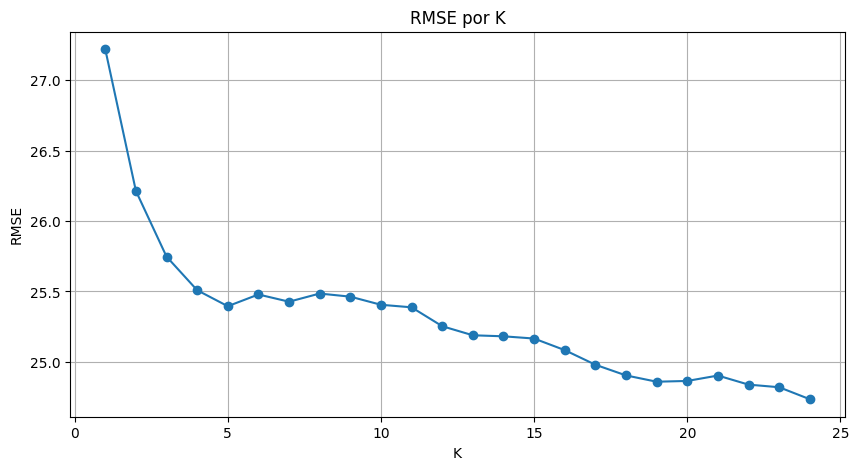

-------------------------------------------------------------------------------------------------------------------


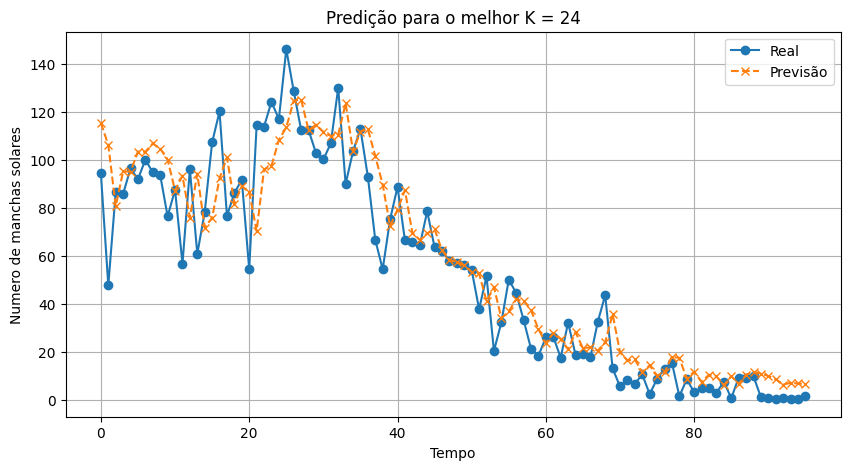

In [6]:
import matplotlib.pyplot as plt

# Usar o melhor K para predição no teste
X_test, Y_test = create_dataset(test_values, best_K)
w_best = weights[best_K]

X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test]
Y_pred = X_test_bias @ weights[best_K]

# Gráfico RMSE por K
plt.figure(figsize=(10, 5))
plt.plot(list(errors.keys()), list(errors.values()), marker='o')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('RMSE por K')
plt.grid(True)
plt.show()

print("-"*115)
# Gráfico Previsão x Real
plt.figure(figsize=(10, 5))
plt.plot(range(len(Y_test)), Y_test, label='Real', marker='o')
plt.plot(range(len(Y_pred)), Y_pred, label='Previsão',linestyle="--", marker='x')
plt.xlabel('Tempo')
plt.ylabel('Numero de manchas solares')
plt.title(f'Predição para o melhor K = {best_K}')
plt.legend()
plt.grid(True)
plt.show()


## <center>**Exercício 2 - Mapeamento não-linear**<center/>

Agora, vamos explorar um modelo de predição linear que utiliza como entrada valores obtidos a partir de transformações não-lineares do vetor $x(n)$. Em outras palavras, os atributos que efetivamente são combinados linearmente na predição resultam de mapeamentos não-lineares dos atrasos da série presentes no vetor original $x(n)$. No caso, vamos gerar T atributos transformados da seguinte forma:

$$ x'_k(n) = \tanh(w_k^T x(n)) $$  

para $k = 1, ..., T$ , $n = 1, ... , N$. Os vetores wk tem seus elementos gerados aleatoriamente de acordo com uma distribuição uniforme.

**Curiosidade:** a estrutura explorada neste exercício corresponde, na realidade, a uma rede neural conhecida como extreme learning machine (ELM).

• Huang, G.-B., Zhu, Q.-Y., e Siew, C.-K. (2006). Extreme learning machine: theory and applications. Neurocomputing, 70, 489–501.

Utilizando um esquema de validação cruzada do tipo *k-fold*, juntamente com a técnica *ridge regression* para a regularização do modelo:

**a)** Apresente o gráfico com a média dos valores de RMSE do preditor em função do número de atributos (T) utilizados, desde $T = 1$ a $T = 100$. Neste caso, considere $K = 8$ (número de atrasos presentes no vetor $x(n)$).

**b)** Apresente o melhor valor do parâmetro de regularização obtido para cada valor de $T$.

**c)** Por fim, aplique o modelo com os melhores valores de $λ$ (regularização) e de $T$ aos dados de teste. Meça o desempenho em termos de RMSE e mostre o gráfico com as amostras de teste da série temporal e as respectivas estimativas geradas pela melhor versão do preditor.

<br>
<br>
<br>


**Observação:** neste exercício, é preciso levar em consideração a escala dos valores da série ao se pensar no intervalo admissível para os coeficientes aleatórios das projeções.
Também é possível tratar esta questão através de normalizações. Contudo, os valores de RMSE e a exibição da série de teste estimada devem ser referentes ao domínio original do problema.

## Extração dos dados

In [7]:
import numpy as np
import pandas as pd

df = pd.read_csv('monthly-sunspots.csv')
# df.head()
# Renomeia coluna para que o df fique melhor formatado
df.rename(columns={"Monthly Mean Total Sunspot Number": "Sunspots"}, inplace=True)
# Converte para numpy e prepara dados para normalização futura
data = df['Sunspots'].values.astype(float)

# Função que agrupa vetores de entrada com base no atraso
def create_dataset(series, K):
  X, Y= [], []
  for i in range(K, len(series)):
    X.append(series[i-K:i]) # vetor de atrasos
    Y.append(series[i]) # valor futuro

  # print(np.array(X))
  # print(np.array(Y))
  return np.array(X), np.array(Y)

# Definição do número de atrasos, com base no enunciado
K = 8
X, Y = create_dataset(data, K)

# Mostra dimensões de X e Y
print(f"Dimensões de X: {X.shape}, Dimensão de Y: {Y.shape}")



Dimensões de X: (3244, 8), Dimensão de Y: (3244,)


## Normalização dos dados -- Z-score


A normalização pelo **Z-Score** transforma os dados para que tenham:  
- **Média = 0**  
- **Desvio padrão = 1**  

A fórmula do **Z-Score** para um dado $x_i$ é:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

Onde:
- $\mu$ = média dos dados  
- $\sigma$ = desvio padrão dos dados  
- $z_i$ = valor normalizado de $x_i$  

Essa técnica faz com que os valores da série fiquem centralizados e distribuídos de maneira mais uniforme.



In [37]:
# Normalização Z-score

mean_X, std_X = X.mean(), Y.std()
mean_Y, std_Y = Y.mean(), Y.std()

X_norm = (X - mean_X) / std_X
Y_norm = (Y - mean_Y) / std_Y

print(f"Média de X: {mean_X}, Desvio padrão de X: {std_X}")
print(f"Média de Y: {mean_Y}, Desvio padrão de Y: {std_Y}")


Média de X: 82.15132167077682, Desvio padrão de X: 67.90287070188027
Média de Y: 81.97718865598027, Desvio padrão de Y: 67.90287070188027


## Geração de atributos não-lineares

Agora, aplicamos a transformação não-linear $tanh$ aos dados de entrada usando vetores $w_k$ gerados aleatoriamente.

$$ x'_k(n) = \tanh(w_k^T x(n)) $$

Os pesos $w_k$ são gerados aleatoriamente dentro do intervalo $[-1, 1]$ apropriado para a natureza da *tangente hiperbólica*.

In [19]:
def transf_features(X, T):
  # Gera T atributos transformados via tanh(.)

  # A função np.random.seed(42) define um estado inicial fixo para o gerador de
  # números aleatórios da biblioteca NumPy. Isso significa que, ao executar
  # código que depende de números aleatórios (como np.random.uniform(-1,1) ou
  # np.random.randn()), os mesmos valores aleatórios serão gerados todas as vezes.
  np.random.seed(42)

  W = np.random.uniform(-1, 1, (T, X.shape[1]))
  X_transf = np.tanh(X @ W.T)
  return X_transf

# Definição do número de atributos não-lineares
# *** Trecho para debug
# T = 10
# X_transformed = transf_features(X_norm, T)

# # Mostra dimensões de X_transf
# print(f"Dimensões de X_transf: {X_transformed.shape}")

## Ridge regression

A regressão Ridge adiciona um termo de regularização para evitar *overfitting*:

$$
w = (X^T X + \lambda I)^{-1} X^T Y
$$


In [20]:
def ridge_regression(X, Y, lambda_m):
  I = np.eye(X.shape[1]) # Matriz identidade
  return np.linalg.inv(X.T @ X + lambda_m * I) @ X.T @ Y

# ***** Debug
# Teste inicial da função com lambda = 0.1
# lambda_test = 0.1
# w_ridge = ridge_regression(X_transformed, Y_norm, lambda_test)

# print(f"Pesos obtidos com Ridge Regression: {w_ridge}")



## Validação cruzada para escolha de $T$ (atributos) e $λ$ (regularização)

Sobre o intervalo de $λ$:

A *regularização L2* adiciona um termo $ \lambda \cdot ||w||^2 $ à função de custo, onde $ w $ é o vetor de pesos e $ \lambda $ é o parâmetro de regularização. O valor de $ \lambda $ controla o quanto queremos penalizar os pesos grandes.

- Se $ \lambda $ for muito pequeno (próximo de zero), a regularização terá pouco efeito, e o modelo pode se ajustar excessivamente aos dados (overfitting).
- Se $ \lambda $ for muito grande, o modelo será fortemente regularizado, o que pode levar a *underfitting*, ou seja, o modelo não será capaz de capturar a complexidade dos dados.

A distribuição logarítmica garante que você explore **valores de $ \lambda $ em uma ampla gama**, indo desde um valor muito pequeno (próximo de zero, onde a regularização é quase inexistente) até um valor muito grande (onde a regularização é muito forte). Isso ajuda a encontrar um valor de $ \lambda $ que seja adequado para equilibrar o ajuste e a regularização.

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Definindo os parametros
T_values = range(1, 101)
lambda_values = np.logspace(-5, 5, 10) # cria um vetor de valores de lambda
                                       # distribuídos logaritmicamente
                                       # entre 10^(-4) e 10^4, com um total de
                                       # 10 valores.
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_rmse = float("inf")
best_T, best_lambda = None, None
rmse_results = []

for T in T_values:
  X_transformed = transf_features(X_norm, T)
  fold_errors = []
  for lambda_m in lambda_values:
    errors = []

    for train_idx, val_idx in kf.split(X_transformed):
      X_train, X_val = X_transformed[train_idx], X_transformed[val_idx]
      Y_train, Y_val = Y_norm[train_idx], Y_norm[val_idx]

      w_ridge = ridge_regression(X_train, Y_train, lambda_m)
      Y_pred = X_val @ w_ridge
      errors.append(np.sqrt(mean_squared_error(Y_val, Y_pred)))

    mean_error = np.mean(errors)
    fold_errors.append((lambda_m, mean_error))

    # Melhor lambda para este T
    lambda_opt, rmse_opt = min(fold_errors, key=lambda x: x[1])
    rmse_results.append((T, lambda_opt, rmse_opt))

    if rmse_opt < best_rmse:
      best_rmse = rmse_opt
      best_T = T
      best_lambda = lambda_opt

# Exibindo melhores parâmetros
print(f"Melhor T: {best_T}, Melhor lambda: {best_lambda}, Melhor RMSE: {best_rmse}")

Melhor T: 98, Melhor lambda: 3.593813663804626, Melhor RMSE: 0.40246922512715466


## Avaliar no *Conjunto de Testes* e gerar gráficos

RMSE final: 26.222990964051565


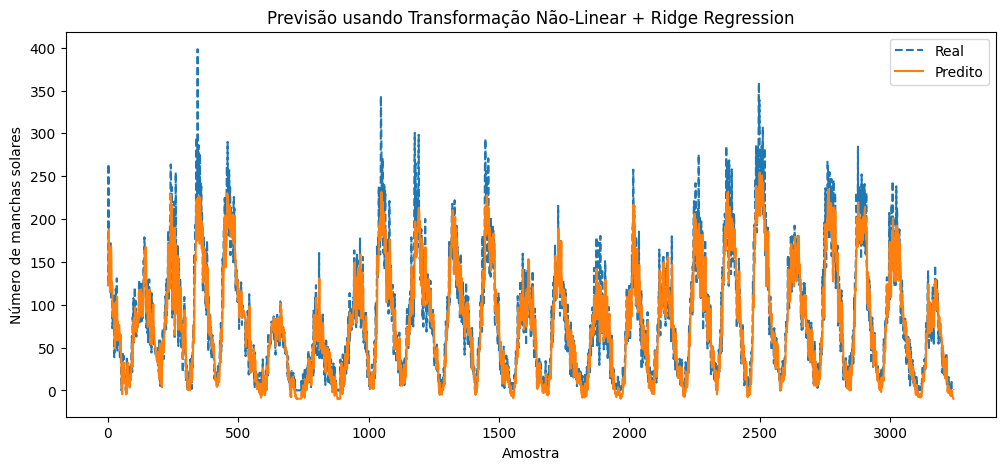

In [39]:
import matplotlib.pyplot as plt

# Gerar atributos transformados com o melhor T
X_final = transf_features(X_norm, best_T)

# Treinar o modelo com os melhores parâmetros
w_final = ridge_regression(X_final, Y_norm, best_lambda)

# Previsão no conjunto de testes
Y_pred_norm = X_final @ w_final

# Retornar os valores à escala original
Y_pred = Y_pred_norm * std_Y + mean_Y
Y_real = Y_norm * std_Y + mean_Y # Desnormalização dos valores reais

# Erro final
final_rmse = np.sqrt(mean_squared_error(Y_real, Y_pred))
print(f"RMSE final: {final_rmse}")

# Plotando gráficos
plt.figure(figsize=(12, 5))
plt.plot(Y_real, label="Real", linestyle="dashed")
plt.plot(Y_pred, label="Predito")
plt.legend()
plt.xlabel("Amostra")
plt.ylabel("Número de manchas solares")
plt.title("Previsão usando Transformação Não-Linear + Ridge Regression")
plt.show()